In [1]:
import tone
import utils
from utils import *

tone.utils.ipython.autoreload(utils)
tone.utils.learning.ignore_warning()
device = tone.utils.learning.try_use_device()
device

device(type='cuda')

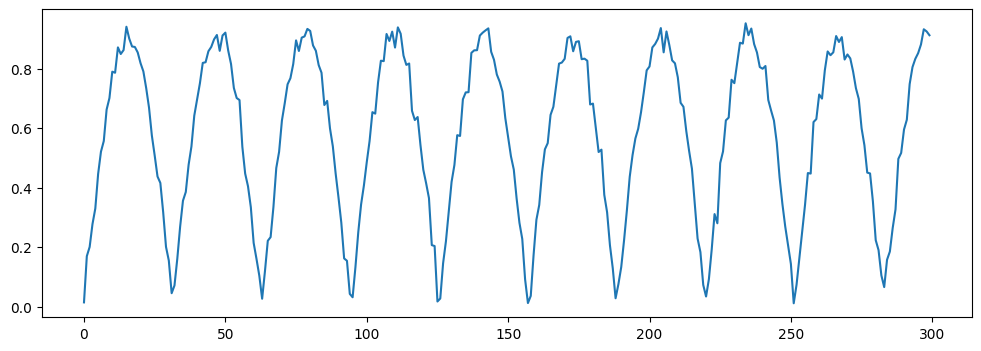

In [2]:
dataset = utils.SineDataset(lags=12)

fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(dataset.data[:300].cpu())
plt.show()


In [3]:
class Model(nn.Module):

    def forward(self, x: torch.Tensor):
        return self.model(x)

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model = nn.Sequential(
            nn.LazyLinear(128),
            nn.LazyBatchNorm1d(),
            nn.Sigmoid(),

            nn.LazyLinear(32),
            nn.LazyBatchNorm1d(),
            nn.Sigmoid(),

            nn.LazyLinear(1),
            nn.Sigmoid()
        )

In [4]:

lags = 12
batch_size = 256
epoch = 20

dataloader = torch.utils.data.DataLoader(
    dataset=utils.SineDataset(lags),
    batch_size=batch_size,
    drop_last=True,
    generator=torch.Generator(device=device),
    shuffle=False,
)
batch = len(dataloader)

model = Model()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

progress = []

with tqdm(total=epoch * batch) as bar:
    for e in range(epoch):
        for i, (x, t) in enumerate(dataloader):
            bar.set_description(f"({e + 1:02}/{epoch}) | ({i + 1:02}/{batch})")
            y = model.forward(x)
            loss = criterion(y, t.reshape(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress.append(loss.item())
            bar.update()
            bar.set_postfix(loss=f"{loss.item():0.6}")


(20/20) | (39/39): 100%|██████████| 780/780 [00:04<00:00, 170.19it/s, loss=0.00108678] 


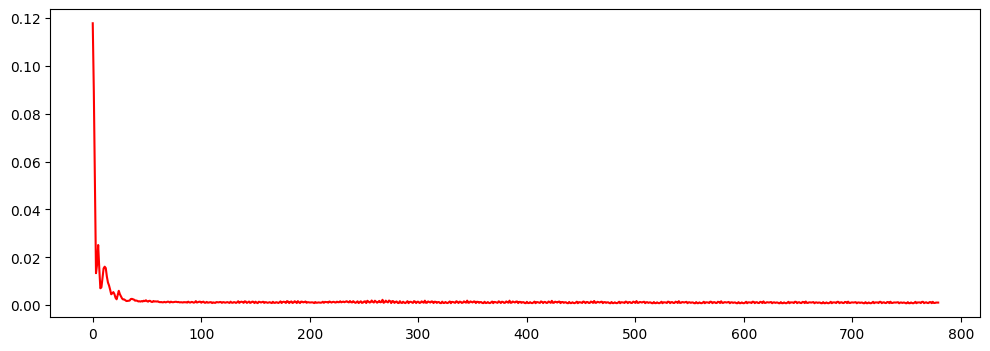

In [5]:
fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(progress, 'r')
plt.show()
plt.close()

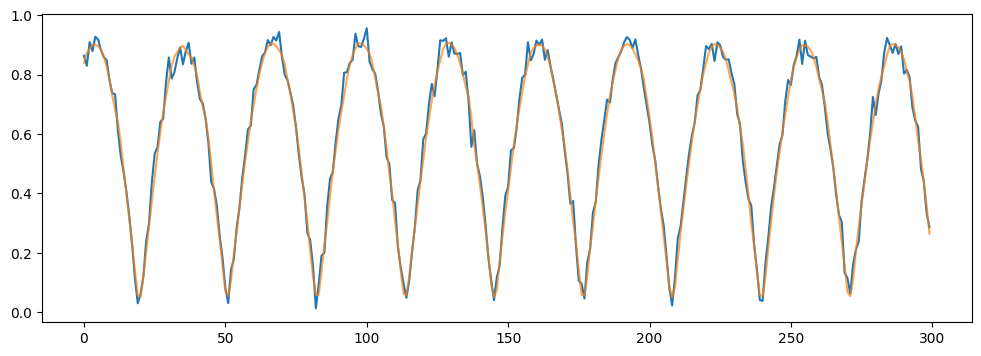

In [6]:
dataloader = torch.utils.data.DataLoader(
    dataset=utils.SineDataset(lags, train=False),
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    generator=torch.Generator(device=device),
)
model.eval()

real = []
pred = []
for x, t in dataloader:
    y = model.forward(x)
    real.append(t)
    pred.append(y)


real = torch.cat(real)
pred = torch.cat(pred)

fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(real.detach().cpu()[:300])
ax.plot(pred.detach().cpu()[:300], alpha=0.7)

plt.show()
plt.close()